In [71]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from lazypredict.Supervised import LazyClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA #tester prince ? 
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from skopt import BayesSearchCV
from lightgbm import LGBMClassifier
from skopt.space import Categorical, Real, Integer
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
import time

In [2]:
#################################### A MODIFIER SELON SA PROPRE ARBORESCENCE
project_path = 'D:/Projet/mai25_bds_extraction/' 
####################################
raw_data_path = os.path.join(project_path, 'data', 'raw')
processed_data_path = os.path.join(project_path, 'data', 'processed')
rvl_cdip_images_path = os.path.join(raw_data_path, 'RVL-CDIP', 'images')

In [3]:
df_all = pd.read_parquet(os.path.join(processed_data_path,"ML_images_100x100", "df_pixels_features.parquet"))

In [4]:
len(df_all.columns)

10019

In [11]:
len(df_all)

400623

# On va travailler sur un échantillon d'abord, parce que sinon je n'ai pas assez de RAM

In [6]:
sample = pd.read_parquet(os.path.join(project_path,'data_sample', 'df_documents_sample_4k_3.parquet'), engine='fastparquet')

In [7]:
sample = sample.drop(columns=['filename', 'rvl_image_path', 'label', 'data_set',
       'iit_image_path', 'iit_individual_xml_path', 'iit_collective_xml_path'])

In [8]:
df = pd.merge(df_all, sample)

In [9]:
len(df.columns)

10019

In [10]:
len(df)

4005

# Création des sets de train, test et validation

In [12]:
df = df.drop(columns=['filename','document_id', 'path','file_path', 'relative_path'])

In [13]:
# On récupère les noms des colonnes sauf 'cat' et 'set'
features = df.columns.difference(['cat', 'set'])

# Split
X_train = df[df['set'] == 'train'][features]
X_val   = df[df['set'] == 'val'][features]
X_test  = df[df['set'] == 'test'][features]

y_train = df[df['set'] == 'train']['cat']
y_val   = df[df['set'] == 'val']['cat']
y_test  = df[df['set'] == 'test']['cat']

In [14]:
for c in X_train.columns:
    if not (isinstance(c, str) and c.startswith('p_')):
        print(c)

bottom_marge
entropy
left_marge
nb_colonnes
nb_lignes
noise
ratio_b
ratio_n
right_marge
sharpness
top_marge
width


# Normalisation des données 

In [15]:
# Liste des colonnes à normaliser
cols_to_normalize = ['top_marge', 'bottom_marge', 'left_marge',
       'right_marge', 'nb_lignes', 'nb_colonnes', 'sharpness', 'noise',
       'ratio_b', 'ratio_n', 'entropy','width']

scaler = RobustScaler()

# Fit sur le train
X_train[cols_to_normalize] = scaler.fit_transform(X_train[cols_to_normalize])

# Transform val et test
X_val[cols_to_normalize] = scaler.transform(X_val[cols_to_normalize])
X_test[cols_to_normalize] = scaler.transform(X_test[cols_to_normalize])

In [16]:
X_train.head()

,bottom_marge,entropy,left_marge,nb_colonnes,nb_lignes,noise,p_0,p_1,p_10,p_100,...,p_9996,p_9997,p_9998,p_9999,ratio_b,ratio_n,right_marge,sharpness,top_marge,width
1,-0.34,1.67,0.00,1.00,1.55,1.70,255,255,255,255,...,255,255,255,255,-1.31,0.59,-0.19,1.52,-0.16,-0.35
2,0.25,-0.01,0.00,0.00,0.27,0.06,255,255,255,255,...,255,255,255,255,-0.04,0.32,0.16,-0.05,-0.18,-0.13
3,-2.98,0.53,2.81,-1.00,-0.64,-0.15,255,39,0,255,...,255,255,255,255,-0.92,1.93,-0.10,0.26,2.73,-0.22
4,0.25,1.20,0.00,-1.00,1.09,1.27,255,255,255,255,...,255,255,255,255,-1.17,1.35,0.58,1.01,-0.18,0.48
5,0.25,-0.37,2.81,1.00,-0.05,-0.39,255,255,255,255,...,255,255,255,255,0.43,-0.56,0.00,-0.30,1.84,-0.35


# Lazy Classifier ?
Bon, trop de colonnes, ça ne tourne pas, donc je commence par faire une PCA pour garder le plus possible de l'information, tout en réduisant drastiquement la nombre de colonnes. 

In [17]:
pca = PCA()
#on va regarder combien il faut garder de dimensions pour ne pas perdre trop d'information. 
coord_pca = pd.DataFrame(data = pca.fit_transform(X_train), 
                         columns =[f'PC{i+1}' for i in range (len(X_train))])
coord_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC3196,PC3197,PC3198,PC3199,PC3200,PC3201,PC3202,PC3203,PC3204,PC3205
0,-910.62,48.98,283.34,204.43,661.37,131.03,363.24,-86.46,282.03,39.08,...,0.15,0.21,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00
1,827.64,-21.73,-304.07,195.04,6.41,-140.93,-37.09,-445.06,-195.64,-159.72,...,0.11,0.16,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00
2,-4390.68,362.30,-751.70,2360.17,-916.39,3396.21,-1105.09,405.57,-202.80,-633.09,...,-0.13,-0.03,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00
3,-521.93,-249.99,597.43,-103.59,702.21,-843.69,-319.55,-176.47,-84.94,-193.23,...,-0.10,-0.24,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00
4,1359.66,149.15,-712.81,-187.66,-577.38,-169.36,256.17,207.65,47.61,16.77,...,0.28,-0.17,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00


In [22]:
CL = pd.DataFrame(data = pca.components_,
                  columns = X_train.columns,
                  index = coord_pca.columns)
CL.head()

,bottom_marge,entropy,left_marge,nb_colonnes,nb_lignes,noise,p_0,p_1,p_10,p_100,...,p_9996,p_9997,p_9998,p_9999,ratio_b,ratio_n,right_marge,sharpness,top_marge,width
PC1,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,...,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00
PC2,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,...,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00
PC3,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00
PC4,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00
PC5,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00


In [25]:
var = pd.DataFrame(data = pca.explained_variance_ratio_,
                  index = coord_pca.columns)
var.head()
# une seule composante explique quasiment 30% de la variance, et après ça chute très très vite...

,0
PC1,0.29
PC2,0.03
PC3,0.02
PC4,0.02
PC5,0.01


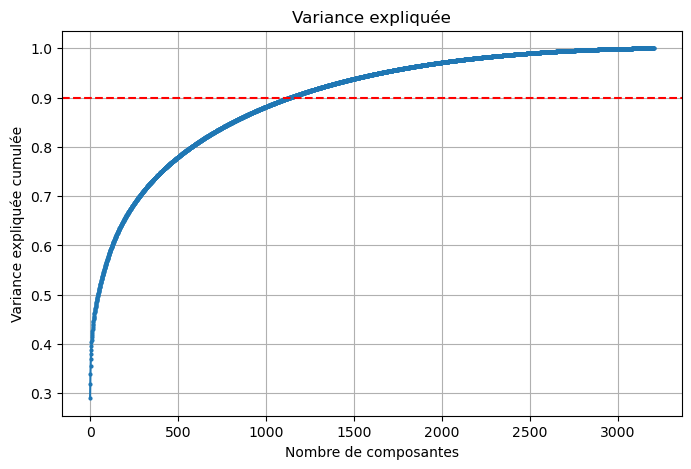

In [32]:
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', ms= 2)
plt.axhline(y = 0.9, color ='r', linestyle = '--')
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance expliquée cumulée")
plt.title("Variance expliquée")
plt.grid(True)
plt.show()


In [39]:
## PCA
n_components = 1000  # ou moins, à tester
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [27]:
clf=LazyClassifier(verbose = 0, 
                   ignore_warnings=True, 
                   custom_metric=None)
models, predictions=clf.fit(X_train_pca, X_test_pca, y_train, y_test)
display(models)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255000
[LightGBM] [Info] Number of data points in the train set: 3205, number of used features: 1000
[LightGBM] [Info] Start training from score -2.769162
[LightGBM] [Info] Start training from score -2.774150
[LightGBM] [Info] Start training from score -2.774150
[LightGBM] [Info] Start training from score -2.774150
[LightGBM] [Info] Start training from score -2.774150
[LightGBM] [Info] Start training from score -2.774150
[LightGBM] [Info] Start training from score -2.769162
[LightGBM] [Info] Start training from score -2.774150
[LightGBM] [Info] Start training from score -2.774150
[LightGBM] [Info] Start training from score -2.774150
[LightGBM] [Info] Start training from score -2.774150
[LightGBM] [Info] Start training from score -2.774150
[LightGBM] [Info] Start training from score -2.769162
[Light

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.35,0.35,None,0.34,202.61
XGBClassifier,0.35,0.35,None,0.34,208.18
RandomForestClassifier,0.27,0.27,None,0.25,28.41
BaggingClassifier,0.27,0.27,None,0.25,66.74
LinearDiscriminantAnalysis,0.25,0.25,None,0.26,3.05
RidgeClassifierCV,0.25,0.25,None,0.23,1.52
RidgeClassifier,0.25,0.25,None,0.23,0.50
BernoulliNB,0.24,0.24,None,0.24,0.47
NearestCentroid,0.24,0.24,None,0.24,0.83


# On se lance dans les classifiers suivants: 
- LGBM
- XGB
- SGD

## LGBM Classifier

In [34]:
from lightgbm import LGBMClassifier

In [35]:
clf_lgbm =LGBMClassifier()

In [41]:
clf_lgbm.fit(X_train_pca, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255000
[LightGBM] [Info] Number of data points in the train set: 3205, number of used features: 1000
[LightGBM] [Info] Start training from score -2.769162
[LightGBM] [Info] Start training from score -2.774150
[LightGBM] [Info] Start training from score -2.774150
[LightGBM] [Info] Start training from score -2.774150
[LightGBM] [Info] Start training from score -2.774150
[LightGBM] [Info] Start training from score -2.774150
[LightGBM] [Info] Start training from score -2.769162
[LightGBM] [Info] Start training from score -2.774150
[LightGBM] [Info] Start training from score -2.774150
[LightGBM] [Info] Start training from score -2.774150
[LightGBM] [Info] Start training from score -2.774150
[LightGBM] [Info] Start training from score -2.774150
[LightGBM] [Info] Start training from score -2.769162
[Light

LGBMClassifier()

In [42]:
y_pred=clf_lgbm.predict(X_test_pca)

In [43]:
cm = pd.crosstab(y_test, y_pred, rownames=['classe réelle'], colnames=['classe prédite'])

Text(0.5, 1.0, 'Matrice de confusion, LGBM, paramètres par défaut')

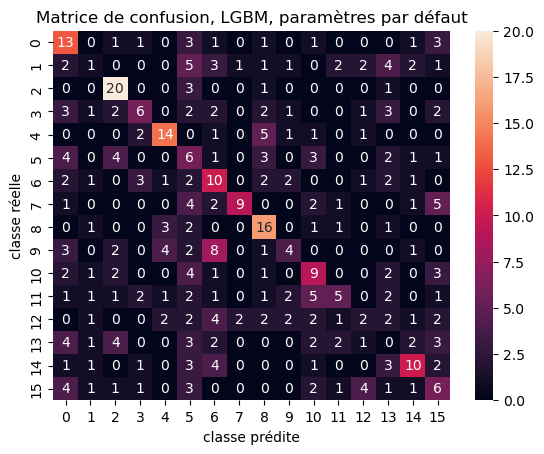

In [47]:
sns.heatmap(cm, annot=True)
plt.title('Matrice de confusion, LGBM, paramètres par défaut')

In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.33      0.52      0.40        25
           1       0.10      0.04      0.06        25
           2       0.54      0.80      0.65        25
           3       0.38      0.24      0.29        25
           4       0.56      0.56      0.56        25
           5       0.13      0.24      0.17        25
           6       0.25      0.37      0.30        27
           7       0.75      0.36      0.49        25
           8       0.44      0.64      0.52        25
           9       0.31      0.16      0.21        25
          10       0.31      0.36      0.33        25
          11       0.38      0.20      0.26        25
          12       0.17      0.08      0.11        25
          13       0.00      0.00      0.00        24
          14       0.48      0.38      0.43        26
          15       0.21      0.24      0.22        25

    accuracy                           0.33       402
   macro avg       0.33   

# Pour la suite, on prend un échantillon un peu plus grand : 10 000 images

In [51]:
sample = pd.read_parquet(os.path.join(project_path,'data_sample', 'df_documents_sample_10k_1.parquet'), engine='fastparquet')
sample = sample.drop(columns=['filename', 'rvl_image_path', 'label', 'data_set',
       'iit_image_path', 'iit_individual_xml_path', 'iit_collective_xml_path'])
df = pd.merge(df_all, sample)
df = df.drop(columns=['filename','document_id', 'path','file_path', 'relative_path'])

In [62]:
print(len(df))

10011


In [52]:
# On récupère les noms des colonnes sauf 'cat' et 'set'
features = df.columns.difference(['cat', 'set'])

# Split
X_train = df[df['set'] == 'train'][features]
X_val   = df[df['set'] == 'val'][features]
X_test  = df[df['set'] == 'test'][features]

y_train = df[df['set'] == 'train']['cat']
y_val   = df[df['set'] == 'val']['cat']
y_test  = df[df['set'] == 'test']['cat']

In [53]:
# Liste des colonnes à normaliser
cols_to_normalize = ['top_marge', 'bottom_marge', 'left_marge',
       'right_marge', 'nb_lignes', 'nb_colonnes', 'sharpness', 'noise',
       'ratio_b', 'ratio_n', 'entropy','width']

scaler = RobustScaler()

# Fit sur le train
X_train[cols_to_normalize] = scaler.fit_transform(X_train[cols_to_normalize])

# Transform val et test
X_val[cols_to_normalize] = scaler.transform(X_val[cols_to_normalize])
X_test[cols_to_normalize] = scaler.transform(X_test[cols_to_normalize])

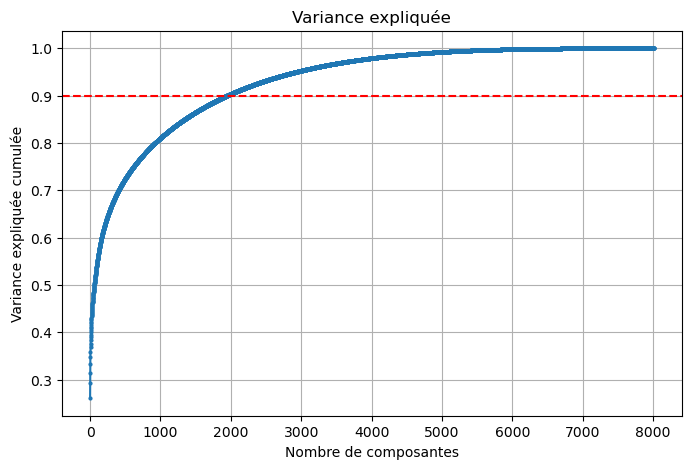

In [54]:
pca = PCA()
#on va regarder combien il faut garder de dimensions pour ne pas perdre trop d'information. 
coord_pca = pd.DataFrame(data = pca.fit_transform(X_train), 
                         columns =[f'PC{i+1}' for i in range (len(X_train))])
CL = pd.DataFrame(data = pca.components_,
                  columns = X_train.columns,
                  index = coord_pca.columns)
var = pd.DataFrame(data = pca.explained_variance_ratio_,
                  index = coord_pca.columns)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', ms= 2)
plt.axhline(y = 0.9, color ='r', linestyle = '--')
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance expliquée cumulée")
plt.title("Variance expliquée")
plt.grid(True)
plt.show()

In [57]:
## PCA
n_components = 2000  
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


In [64]:
X_val_pca = pca.transform(X_val)

## LGBM

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

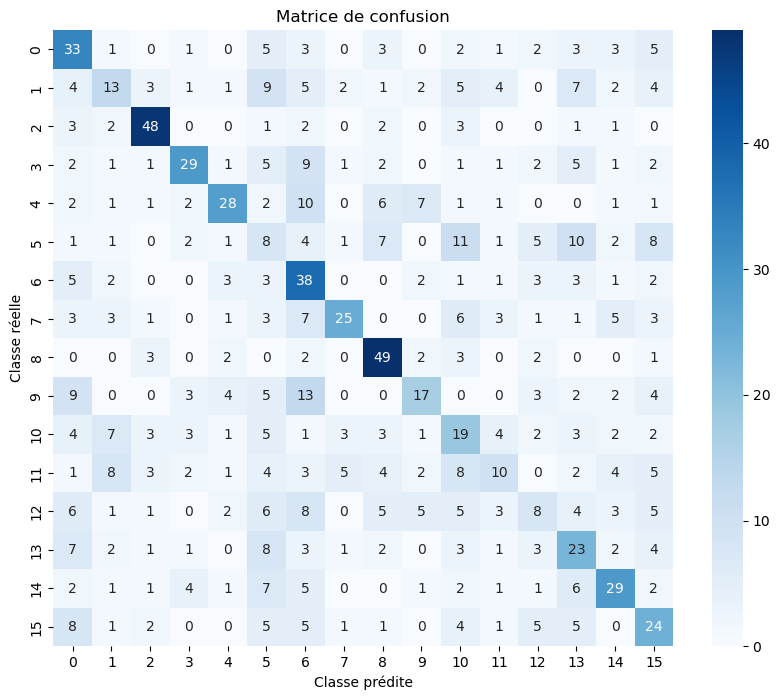


 Rapport sous forme de DataFrame :
    precision  recall  f1-score  support
0        0.37    0.53      0.43    62.00
1        0.30    0.21      0.24    63.00
2        0.71    0.76      0.73    63.00
3        0.60    0.46      0.52    63.00
4        0.61    0.44      0.51    63.00
5        0.11    0.13      0.12    62.00
6        0.32    0.59      0.42    64.00
7        0.64    0.40      0.50    62.00
8        0.58    0.77      0.66    64.00
9        0.44    0.27      0.34    62.00
10       0.26    0.30      0.28    63.00
11       0.31    0.16      0.21    62.00
12       0.22    0.13      0.16    62.00
13       0.31    0.38      0.34    61.00
14       0.50    0.46      0.48    63.00
15       0.33    0.39      0.36    62.00


In [60]:
start_time = time.time()

# 1. Définir l’espace de recherche
search_spaces = {
    'num_leaves': Integer(20, 150),
    'max_depth': Integer(3, 15),
    'learning_rate': Real(0.01, 0.3, 'log-uniform'),
    'n_estimators': Integer(50, 500),
    'min_child_samples': Integer(10, 100),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'reg_alpha': Real(1e-8, 10.0, 'log-uniform'),
    'reg_lambda': Real(1e-8, 10.0, 'log-uniform')
}

# 2. Définir la validation croisée
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 3. Définir le classifieur LightGBM
clf = LGBMClassifier(random_state=25, n_jobs=-1)

# 4. Configurer BayesSearchCV
opt = BayesSearchCV(
    estimator=clf,
    search_spaces=search_spaces,
    n_iter=20,  #nombre de combinaisons qui seront testées
    cv=cv,
    scoring='f1_weighted',  # tu peux aussi tester avec 'balanced_accuracy'
    verbose=2,
    n_jobs=-1,
    random_state=96
)

# 5. Entraîner l’optimiseur
opt.fit(X_train_pca, y_train)

# 6. Afficher les meilleurs paramètres
print("Meilleurs hyperparamètres :")
print(opt.best_params_)
print(f" Meilleur score (f1_weighted, cross-val) : {opt.best_score_:.4f}")

# 7. Prédire avec le meilleur modèle
y_pred = opt.predict(X_test_pca)

# 8. Rapport de classification
print("\n Rapport de classification :")
print(classification_report(y_test, y_pred))

# 9. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()

# 10. (optionnel) DataFrame des scores
report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
print("\n Rapport sous forme de DataFrame :")
print(report_df.head(16))  # Affiche les 16 classes
print('')
print('###############################')
end_time = time.time()
elapsed = end_time - start_time
print(f" Temps d'exécution total : {elapsed / 60:.2f} minutes ({elapsed:.1f} secondes)")

In [61]:
# début 21h16
# à 21h37, deux lignes étaient imprimées
# à 23h21 11 lignes étaient imprimées
# fin ? 

In [63]:
# on lance sur le set de validation : 
best_params = opt.best_params_
X_trainval = np.concatenate([X_train_pca, X_test_pca])
y_trainval = np.concatenate([y_train, y_test])

final_model = LGBMClassifier(**best_params, random_state=91, n_jobs=-1)
final_model.fit(X_trainval, y_trainval)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.232708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510000
[LightGBM] [Info] Number of data points in the train set: 9011, number of used features: 2000
[LightGBM] [Info] Start training from score -2.767607
[LightGBM] [Info] Start training from score -2.774699
[LightGBM] [Info] Start training from score -2.774699
[LightGBM] [Info] Start training from score -2.771147
[LightGBM] [Info] Start training from score -2.774699
[LightGBM] [Info] Start training from score -2.772922
[LightGBM] [Info] Start training from score -2.765842
[LightGBM] [Info] Start training from score -2.774699
[LightGBM] [Info] Start training from score -2.769376
[LightGBM] [Info] Start training from score -2.771147
[LightGBM] [Info] Start training from score -2.772922
[LightGBM] [Info] Start training from score -2.776480
[LightGBM] [Info] Start training from score -2.772922
[Light

NameError: name 'X_val_pca' is not defined

Évaluation sur le set de validation :
              precision    recall  f1-score   support

           0       0.32      0.54      0.40        61
           1       0.17      0.17      0.17        63
           2       0.80      0.84      0.82        63
           3       0.54      0.48      0.50        61
           4       0.69      0.57      0.63        63
           5       0.16      0.19      0.17        63
           6       0.32      0.53      0.40        64
           7       0.75      0.33      0.46        63
           8       0.63      0.80      0.71        61
           9       0.41      0.27      0.33        63
          10       0.33      0.29      0.31        62
          11       0.34      0.23      0.28        64
          12       0.26      0.13      0.17        62
          13       0.24      0.24      0.24        63
          14       0.60      0.61      0.60        61
          15       0.30      0.37      0.33        63

    accuracy                           0.4

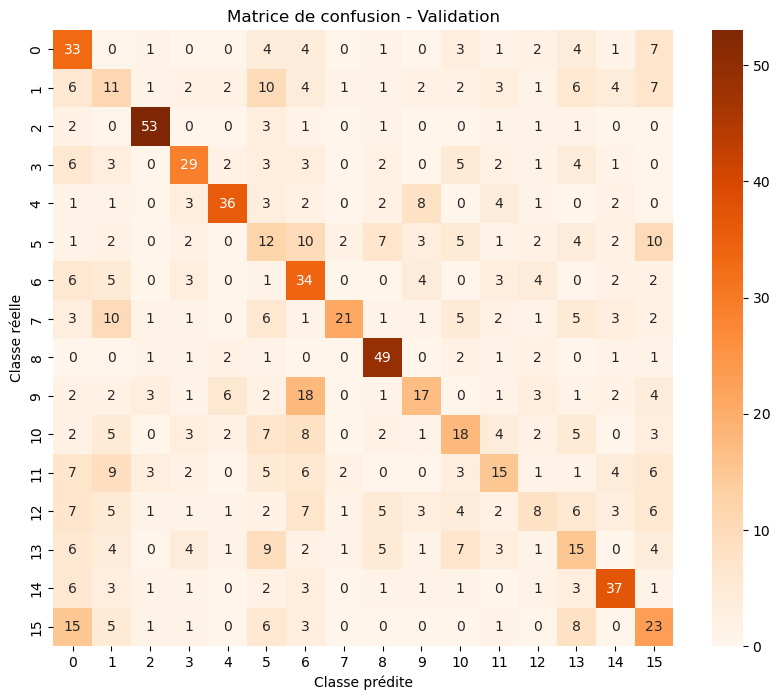

In [65]:
y_val_pred = final_model.predict(X_val_pca)


print("Évaluation sur le set de validation :")
print(classification_report(y_val, y_val_pred))

# Matrice de confusion
cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Oranges')
plt.title("Matrice de confusion - Validation")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()

## XGB Classifier

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

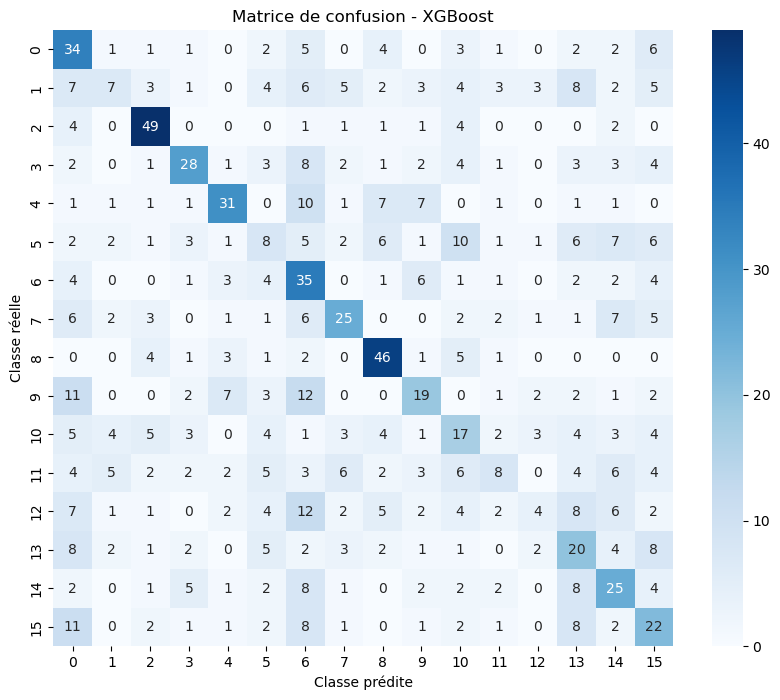


 Rapport sous forme de DataFrame :
    precision  recall  f1-score  support
0        0.31    0.55      0.40    62.00
1        0.28    0.11      0.16    63.00
2        0.65    0.78      0.71    63.00
3        0.55    0.44      0.49    63.00
4        0.58    0.49      0.53    63.00
5        0.17    0.13      0.15    62.00
6        0.28    0.55      0.37    64.00
7        0.48    0.40      0.44    62.00
8        0.57    0.72      0.63    64.00
9        0.38    0.31      0.34    62.00
10       0.26    0.27      0.27    63.00
11       0.30    0.13      0.18    62.00
12       0.25    0.06      0.10    62.00
13       0.26    0.33      0.29    61.00
14       0.34    0.40      0.37    63.00
15       0.29    0.35      0.32    62.00

###############################
 Temps d'exécution total : 1136.31 minutes (68178.3 secondes)


In [67]:
start_time = time.time()

# 1. Espace de recherche pour XGBoost
search_spaces = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(3, 15),
    'learning_rate': Real(0.01, 0.3, 'log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'gamma': Real(0, 5.0),  # min split loss
    'reg_alpha': Real(1e-8, 10.0, 'log-uniform'),
    'reg_lambda': Real(1e-8, 10.0, 'log-uniform')
}

# 2. Cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=93)

# 3. XGBClassifier
clf = XGBClassifier(
    objective='multi:softmax',  # ou 'multi:softprob' si tu veux des proba
    num_class=16,
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=-1,
    random_state=21
)

# 4. BayesSearchCV
opt = BayesSearchCV(
    estimator=clf,
    search_spaces=search_spaces,
    n_iter=20,
    cv=cv,
    scoring='f1_weighted',
    verbose=2,
    n_jobs=-1,
    random_state=56
)

# 5. Entraînement
opt.fit(X_train_pca, y_train)

# 6. Meilleurs hyperparamètres
print("Meilleurs hyperparamètres :")
print(opt.best_params_)
print(f" Meilleur score (f1_weighted, cross-val) : {opt.best_score_:.4f}")

# 7. Prédictions
y_pred = opt.predict(X_test_pca)

# 8. Rapport
print("\n Rapport de classification :")
print(classification_report(y_test, y_pred))

# 9. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion - XGBoost")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()

# 10. DataFrame des scores
report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
print("\n Rapport sous forme de DataFrame :")
print(report_df.head(16))

print('')
print('###############################')
end_time = time.time()
elapsed = end_time - start_time
print(f" Temps d'exécution total : {elapsed / 60:.2f} minutes ({elapsed:.1f} secondes)")

Évaluation sur le set de validation :
              precision    recall  f1-score   support

           0       0.32      0.49      0.39        61
           1       0.17      0.08      0.11        63
           2       0.72      0.89      0.79        63
           3       0.41      0.46      0.43        61
           4       0.58      0.59      0.58        63
           5       0.15      0.14      0.15        63
           6       0.32      0.56      0.41        64
           7       0.52      0.37      0.43        63
           8       0.59      0.79      0.67        61
           9       0.40      0.27      0.32        63
          10       0.32      0.29      0.30        62
          11       0.19      0.08      0.11        64
          12       0.15      0.03      0.05        62
          13       0.17      0.22      0.20        63
          14       0.46      0.59      0.51        61
          15       0.26      0.29      0.27        63

    accuracy                           0.3

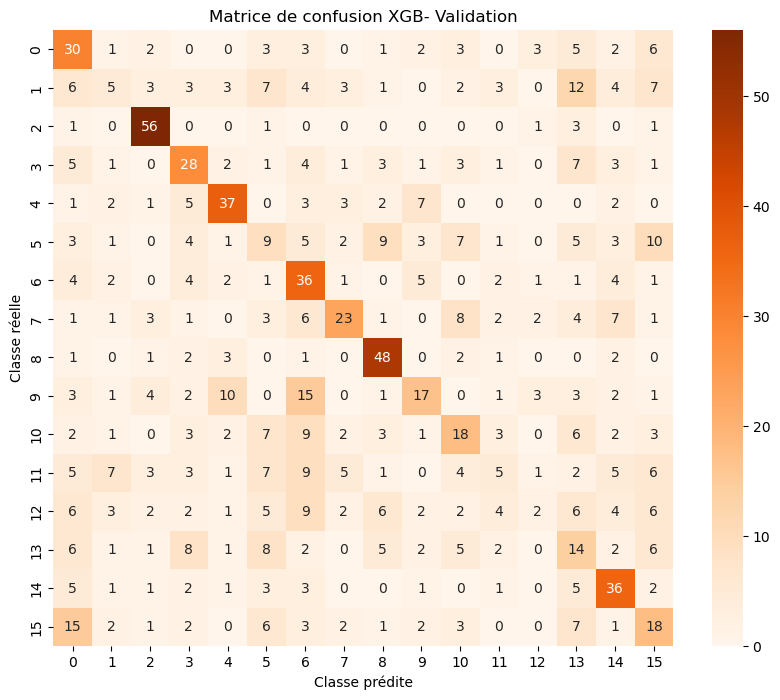

In [74]:
# on lance sur le set de validation : 
best_params_1 = opt.best_params_
X_trainval = np.concatenate([X_train_pca, X_test_pca])
y_trainval = np.concatenate([y_train, y_test])

final_model_1 = XGBClassifier(**best_params_1, random_state=91, n_jobs=-1)
final_model_1.fit(X_trainval, y_trainval)

y_val_pred_1 = final_model_1.predict(X_val_pca)


print("Évaluation sur le set de validation :")
print(classification_report(y_val, y_val_pred_1))

# Matrice de confusion
cm_val_1 = confusion_matrix(y_val, y_val_pred_1)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val_1, annot=True, fmt='d', cmap='Oranges')
plt.title("Matrice de confusion XGB- Validation")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()

## SGD Classifier

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

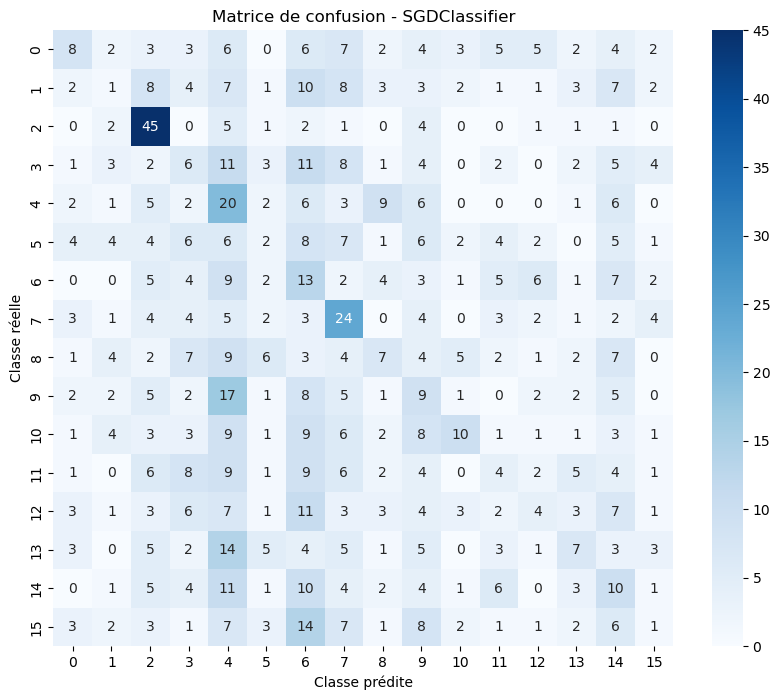


 Rapport sous forme de DataFrame :
    precision  recall  f1-score  support
0        0.24    0.13      0.17    62.00
1        0.04    0.02      0.02    63.00
2        0.42    0.71      0.53    63.00
3        0.10    0.10      0.10    63.00
4        0.13    0.32      0.19    63.00
5        0.06    0.03      0.04    62.00
6        0.10    0.20      0.14    64.00
7        0.24    0.39      0.30    62.00
8        0.18    0.11      0.14    64.00
9        0.11    0.15      0.13    62.00
10       0.33    0.16      0.22    63.00
11       0.10    0.06      0.08    62.00
12       0.14    0.06      0.09    62.00
13       0.19    0.11      0.14    61.00
14       0.12    0.16      0.14    63.00
15       0.04    0.02      0.02    62.00
 Temps d'exécution total : 18.79 minutes (1127.6 secondes)


In [72]:
start_time = time.time()

search_spaces = {
    'loss': Categorical(['hinge', 'log_loss', 'modified_huber', 'squared_hinge']),
    'penalty': Categorical(['l2', 'l1', 'elasticnet']),
    'alpha': Real(1e-6, 1e-2, prior='log-uniform'),
    'learning_rate': Categorical(['constant', 'optimal', 'invscaling', 'adaptive']),
    'eta0': Real(1e-4, 1e-1, prior='log-uniform'),
    'max_iter': Integer(1000, 3000),
    'tol': Real(1e-5, 1e-2, prior='log-uniform')
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=93)

clf_3 = SGDClassifier(
    random_state=21,
    n_jobs=-1,
    early_stopping=True
)

opt_3 = BayesSearchCV(
    estimator=clf_3,
    search_spaces=search_spaces,
    n_iter=30,
    cv=cv,
    scoring='f1_weighted',
    verbose=2,
    n_jobs=-1,
    random_state=56
)

opt_3.fit(X_train_pca, y_train)

print("Meilleurs hyperparamètres :")
print(opt_3.best_params_)
print(f" Meilleur score (f1_weighted, cross-val) : {opt_3.best_score_:.4f}")

y_pred_3 = opt_3.predict(X_test_pca)

print("\n Rapport de classification :")
print(classification_report(y_test, y_pred_3))

cm_3 = confusion_matrix(y_test, y_pred_3)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_3, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion - SGDClassifier")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()

report_df = pd.DataFrame(classification_report(y_test, y_pred_3, output_dict=True)).transpose()
print("\n Rapport sous forme de DataFrame :")
print(report_df.head(16))

end_time = time.time()
elapsed = end_time - start_time
print(f" Temps d'exécution total : {elapsed / 60:.2f} minutes ({elapsed:.1f} secondes)")

Évaluation sur le set de validation :
              precision    recall  f1-score   support

           0       0.19      0.23      0.21        61
           1       0.18      0.16      0.17        63
           2       0.54      0.79      0.65        63
           3       0.13      0.15      0.14        61
           4       0.21      0.33      0.26        63
           5       0.09      0.06      0.07        63
           6       0.16      0.17      0.17        64
           7       0.30      0.27      0.28        63
           8       0.13      0.16      0.15        61
           9       0.14      0.11      0.12        63
          10       0.17      0.15      0.16        62
          11       0.16      0.14      0.15        64
          12       0.09      0.05      0.06        62
          13       0.09      0.08      0.08        63
          14       0.23      0.20      0.21        61
          15       0.17      0.17      0.17        63

    accuracy                           0.2

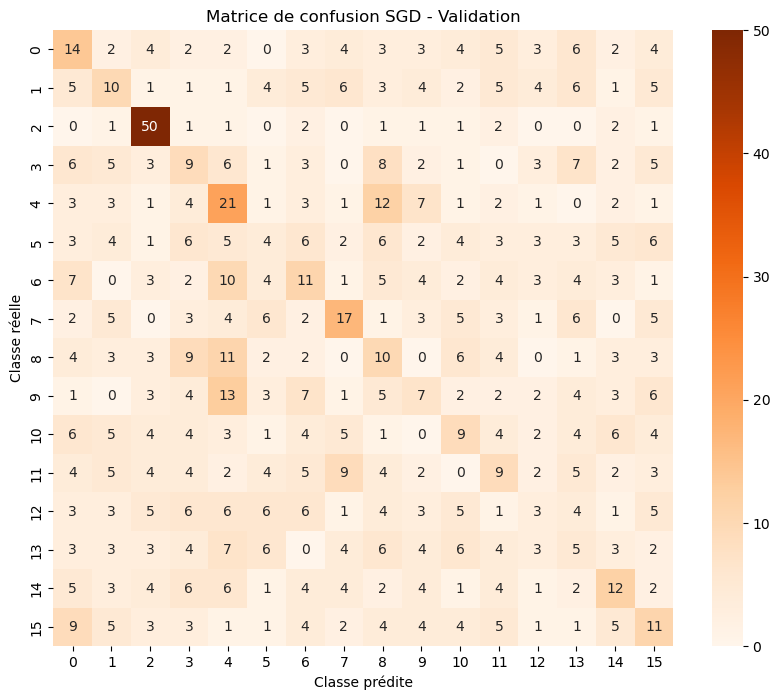

In [76]:
# on lance sur le set de validation : 
best_params_3 = opt_3.best_params_
X_trainval = np.concatenate([X_train_pca, X_test_pca])
y_trainval = np.concatenate([y_train, y_test])

final_model_3 = SGDClassifier(**best_params_3, random_state=35, n_jobs=-1)
final_model_3.fit(X_trainval, y_trainval)

y_val_pred_3 = final_model_3.predict(X_val_pca)


print("Évaluation sur le set de validation :")
print(classification_report(y_val, y_val_pred_3))

# Matrice de confusion
cm_val_3 = confusion_matrix(y_val, y_val_pred_3)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val_3, annot=True, fmt='d', cmap='Oranges')
plt.title("Matrice de confusion SGD - Validation")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()

In [ ]:
# On a établi que le meilleur était le LGBM